# Importing librairies

In [ ]:
import tensorflow as tf 
print(tf.__version__)

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, add
from tensorflow.keras.models import Model 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt 
from glob import glob 

2.9.2


# Config

In [ ]:
IMAGE_SIZE= [214,214]
epochs= 16
batch_size=128

# Loading data 

In [ ]:
!wget -nc  https://lazyprogrammer.me/course_files/blood_cell_images.zip

--2022-10-21 23:26:03--  https://lazyprogrammer.me/course_files/blood_cell_images.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M  16.8MB/s    in 10s     

2022-10-21 23:26:15 (10.4 MB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]



In [ ]:
!ls

blood_cell_images.zip  sample_data


In [ ]:
!unzip -nq blood_cell_images

In [ ]:
train_path = "blood_cell_images/TRAIN"
validation_path = "blood_cell_images/TEST"

In [ ]:
image_files = glob(train_path + "/*/*.jp*g")
validation_image_files = glob(validation_path + "/*/*.jp*g")
folders = glob(train_path+"/*")

# Displaying images 

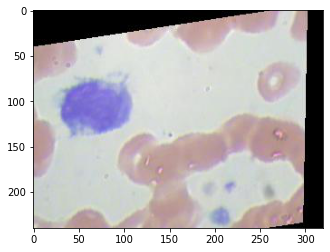

In [ ]:
#Looking at an image : 
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [ ]:
def identity_block(input_, kernel_size, filters) : 
    f1,f2,f3 = filters 

    x=Conv2D(f1,(1,1), 
             #kernel_initializer="he_normal",
             )(input_)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3,(1,1))(x)
    x=BatchNormalization()(x)

    x=add([x,input_])
    x = Activation("relu")(x)
    return(x)

In [ ]:
def conv_block(input_, kernel_size, filters, strides= (2,2)):
    f1,f2,f3 = filters 
    x=Conv2D(f1,(1,1), strides= strides)(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size , padding = "same") (x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(f3, (1,1), padding="same")(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv2D(f3, (1,1), strides= strides)(input_)
    shortcut = BatchNormalization()(shortcut)

    x=add([x,shortcut])
    x=Activation('relu')(x)

    return x

In [ ]:
#Building custom ResNet : 

#Stage 1 : 
i = Input(shape= IMAGE_SIZE+[3])
x = ZeroPadding2D(padding=(3,3))(i)
x = Conv2D(64, (7,7), strides=(2,2), padding="valid") (x)

x = BatchNormalization()(x)
x = Activation("relu")(x)
x= ZeroPadding2D(padding =(1,1))(x)
x = MaxPooling2D((3,3), strides=(2,2))(x)

x = conv_block(x, 3, [64, 64, 256], strides =(1,1))
x=identity_block(x, 3 , [64, 64, 256])
x= identity_block(x, 3, [64, 64 , 256])

x = conv_block(x, 3, [128 , 128 , 512])
x = identity_block(x, 3, [128, 128 , 512])
x = identity_block(x, 3, [128, 128 , 512])
x = identity_block(x, 3, [128, 128 , 512])

# Stage 2 : 
x = Flatten()(x)
prediction = Dense(len(folders), activation ="softmax")(x)

model = Model(inputs= i, outputs = prediction)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 214, 214, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 220, 220, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 107, 107, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
model.compile(optimizer =Adam(learning_rate= 0.0001), loss= "sparse_categorical_crossentropy", metrics= ["accuracy"])

In [ ]:
def preprocess_input2(x): 
    x /= 127.5
    x-=1.
    return x 

In [ ]:
train_gen= ImageDataGenerator(
    rotation_range= 20 , 
    width_shift_range= 0.1, 
    height_shift_range =0.1, 
    shear_range=0.1,
    zoom_range=0.2, 
    horizontal_flip = True, 
    vertical_flip= True, 
    preprocessing_function = preprocess_input2
)

In [ ]:
val_gen =ImageDataGenerator(
    preprocessing_function =preprocess_input2
)

In [ ]:
# We test the generator to see how it works and some other useful things 

#get label mapping for confusion matrix plot later : 
test_gen = val_gen.flow_from_directory(validation_path, target_size = IMAGE_SIZE, class_mode ="sparse")
print(test_gen.class_indices)
labels= [None] * len(test_gen.class_indices)

for k, v in test_gen.class_indices.items(): 
    labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min:  -1.0 max : 0.94509804


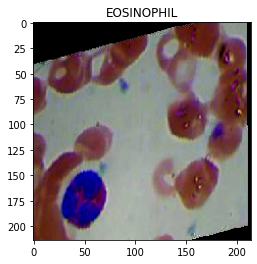

In [ ]:
#Displaying images : 
for x , y in test_gen : 
    print("min: ",x[0].min(), 'max :', x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [ ]:
 #Create generators : 
 train_generator = train_gen.flow_from_directory(
     train_path, 
     target_size= IMAGE_SIZE, 
     shuffle=True, 
     batch_size=batch_size,
     class_mode="sparse"
 )

 valid_generator = val_gen.flow_from_directory(
     validation_path , 
     target_size=IMAGE_SIZE, 
     shuffle=True, 
     batch_size= batch_size, 
     class_mode= "sparse"
 )

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
#fit the model : 
checkpoint_filepath="/tmp/checkpoint"


r=model.fit(train_generator, 
          validation_data=valid_generator,
          epochs=epochs, 
          steps_per_epoch = len(image_files) // batch_size, 
          validation_steps = len(validation_image_files) // batch_size, 
          callbacks =[
              tf.keras.callbacks.EarlyStopping(
                  monitor="loss", patience=3, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint(
                 filepath = checkpoint_filepath , 
                 save_weights_only=True, 
                 monitor="val_accuracy",
                 mode="max",
                 save_best_only=True)
          ]
          )

Epoch 1/16
77/77 [==============================] - 123s 2s/step - loss: 6.2993 - accuracy: 0.2996 - val_loss: 1.4317 - val_accuracy: 0.2549
Epoch 2/16
77/77 [==============================] - 120s 2s/step - loss: 1.5918 - accuracy: 0.5194 - val_loss: 2.2103 - val_accuracy: 0.2492
Epoch 3/16
77/77 [==============================] - 120s 2s/step - loss: 0.8884 - accuracy: 0.7316 - val_loss: 3.2224 - val_accuracy: 0.2619
Epoch 4/16
77/77 [==============================] - 121s 2s/step - loss: 0.5379 - accuracy: 0.8440 - val_loss: 5.4901 - val_accuracy: 0.3030
Epoch 5/16
77/77 [==============================] - 120s 2s/step - loss: 0.3251 - accuracy: 0.9046 - val_loss: 10.6603 - val_accuracy: 0.2808
Epoch 6/16
77/77 [==============================] - 120s 2s/step - loss: 0.3181 - accuracy: 0.9157 - val_loss: 9.5120 - val_accuracy: 0.3405
Epoch 7/16
77/77 [==============================] - 119s 2s/step - loss: 0.2892 - accuracy: 0.9328 - val_loss: 1.7604 - val_accuracy: 0.6945
Epoch 8/16
7

In [ ]:
model.evaluate(valid_generator)

20/20 [==============================] - 6s 279ms/step - loss: 1.0387 - accuracy: 0.8404


[1.0387020111083984, 0.8403699398040771]

In [ ]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

NameError: ignored

In [ ]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
import itertools
def get_confusion_matrix(data_path, N): 
    #we need to see the data in the same order 
    #for both predictions and targets 
    print("generating confusion matrix " , N)
    predictions=[]
    targets=[]
    i = 0 
    n_images=0
    for x, y in val_gen.flow_from_directory(
        data_path, 
        target_size= IMAGE_SIZE,
        shuffle = False, 
        batch_size= batch_size*2
    ): 
        i+=1 
        n_images+=len(y)
        if i % 50== 0 : 
            print(f'{n_images} images processed')

        p =model.predict(x)
        p= np.argmax(p, axis=1)
        y=np.argmax(y, axis=1)  
        predictions = np.concatenate((predictions, p))
        targets= np.concatenate((targets,y))
        if len(targets) >= N : 
            break
    
    cm = confusion_matrix(targets , predictions)
    return cm 

def plot_confusion_matrix(cm, classes, normalize=False, title="confusion matrix", cmap = plt.cm.Blues):
    """This function prints and plots the confusion matrix. Normalization can be applied by setting "normalize=True".
    """
    if normalize: 
        cm=cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else : 
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation="nearest", cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks,classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2
    for i , j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j]> thresh else "black"
                 )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted_label")

    plt.show()

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
valid_cm = get_confusion_matrix(validation_path, len(validation_image_files))

generating confusion matrix  9957
Found 9957 images belonging to 4 classes.
8/8 [==============================] - 1s 81ms/step
generating confusion matrix  2487
Found 2487 images belonging to 4 classes.
6/6 [==============================] - 1s 119ms/step


Confusion matrix, without normalization
[[2416   13    1   67]
 [   5 2478    0    0]
 [   2  275 2199    2]
 [ 131   63   41 2264]]


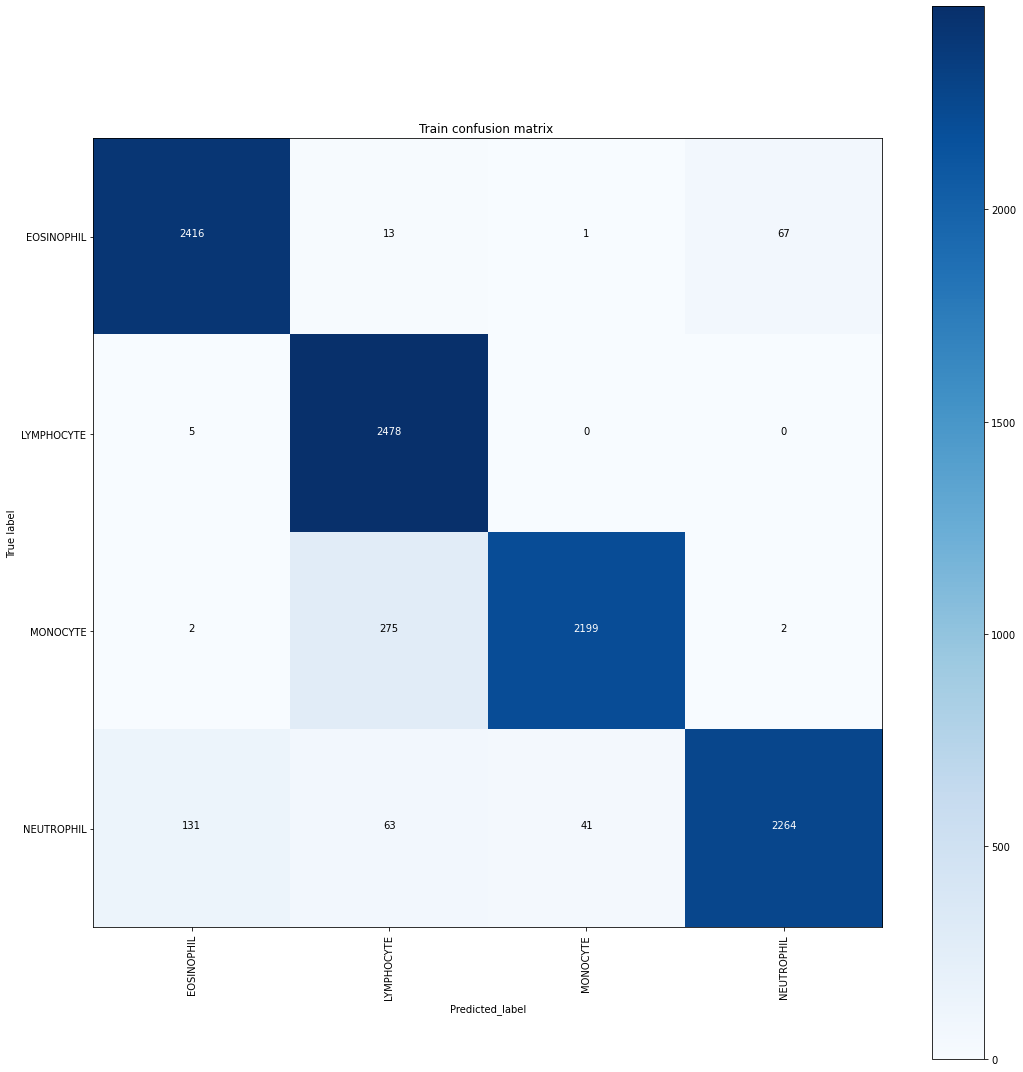

In [ ]:
plot_confusion_matrix(cm, labels, title="Train confusion matrix ")

Confusion matrix, without normalization
[[512  22   1  88]
 [  6 583  31   0]
 [ 79  25 476  40]
 [ 75  14  16 519]]


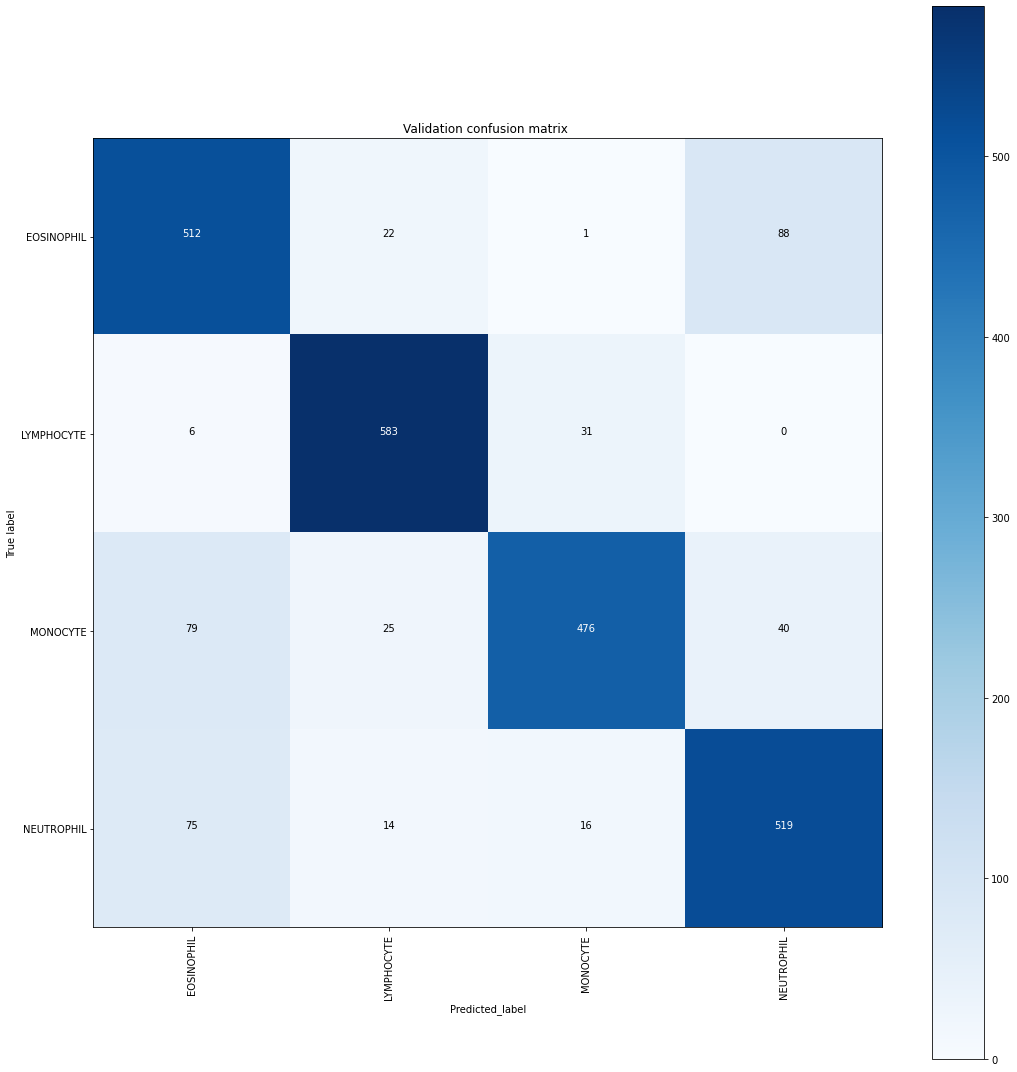

In [ ]:
plot_confusion_matrix(valid_cm, labels, title="Validation confusion matrix ")

In [ ]:
np.trace(cm)/cm.sum()

0.9397408858089786

In [ ]:
np.trace(valid_cm) / valid_cm.sum()

0.8403699236027342

# Comparison with a pre trained ResNet model : 

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input 
res = ResNet50(input_shape= IMAGE_SIZE+ [3], weights="imagenet", include_top=False)

In [ ]:
for layer in res.layers : 
    layer.trainable= False

In [ ]:
#Adding our layers : 
x=Flatten()(res.output)
#x = Dense(32, activation="relu")(x)#example 
predictions = Dense(len(folders),activation="softmax")(x)

#Building the final model : 
model= Model(res.input, predictions)

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 214, 214, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 220, 220, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 107, 107, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model.compile(optimizer ="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#Create an instance of data generator : 
train_gen=  ImageDataGenerator( 
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

val_gen =ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
#Testing the generator to see how it works : 
#get label mapping for confusion matrix plot later : 

test_gen=val_gen.flow_from_directory(validation_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k,v in test_gen.class_indices.items(): 
    labels[v] = k


Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min -123.68 max :  150.061


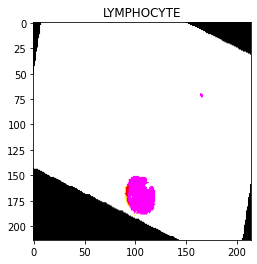

In [ ]:
# Colors are strange because resnet weights are BGR : 
for x, y in test_gen : 
    print("min", x[0].min(), "max : ",x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

## Creating generators 

In [ ]:
train_generator = train_gen.flow_from_directory(
    train_path, 
    target_size=IMAGE_SIZE, 
    shuffle = True, 
    batch_size=batch_size, 
    class_mode= "sparse"
)

valid_generator= val_gen.flow_from_directory(
    validation_path, 
    target_size=IMAGE_SIZE, 
    shuffle=False, 
    batch_size=batch_size, 
    class_mode="sparse"
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
#fit the model : 
checkpoint_filepath="/tmp/checkpoint"


r=model.fit(train_generator, 
          validation_data=valid_generator,
          epochs=epochs, 
          steps_per_epoch = len(image_files) // batch_size, 
          validation_steps = len(validation_image_files) // batch_size, 
          callbacks =[
              tf.keras.callbacks.EarlyStopping(
                  monitor="loss", patience=3, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint(
                 filepath = checkpoint_filepath , 
                 save_weights_only=True, 
                 monitor="val_accuracy",
                 mode="max",
                 save_best_only=True)
          ]
          )

Epoch 1/16
77/77 [==============================] - 150s 2s/step - loss: 2.5597 - accuracy: 0.5336 - val_loss: 9620.8984 - val_accuracy: 0.2360
Epoch 2/16
77/77 [==============================] - 140s 2s/step - loss: 0.3694 - accuracy: 0.8555 - val_loss: 3.8497 - val_accuracy: 0.4844
Epoch 3/16
77/77 [==============================] - 140s 2s/step - loss: 0.2319 - accuracy: 0.9059 - val_loss: 0.3862 - val_accuracy: 0.8668
Epoch 4/16
77/77 [==============================] - 139s 2s/step - loss: 0.1890 - accuracy: 0.9249 - val_loss: 0.5665 - val_accuracy: 0.8462
Epoch 5/16
77/77 [==============================] - 139s 2s/step - loss: 0.1494 - accuracy: 0.9399 - val_loss: 0.3129 - val_accuracy: 0.8910
Epoch 6/16
77/77 [==============================] - 139s 2s/step - loss: 0.1216 - accuracy: 0.9512 - val_loss: 0.5688 - val_accuracy: 0.8787
Epoch 7/16
77/77 [==============================] - 140s 2s/step - loss: 0.1172 - accuracy: 0.9547 - val_loss: 0.3908 - val_accuracy: 0.9009
Epoch 8/16

In [ ]:
model.evaluate(valid_generator)

20/20 [==============================] - 9s 414ms/step - loss: 0.5971 - accuracy: 0.8995


[0.5970648527145386, 0.8994773030281067]

### Using the model with the best results on the validation dataset 

In [ ]:
model.load_weights(checkpoint_filepath)
model.evaluate(valid_generator)

20/20 [==============================] - 8s 387ms/step - loss: 0.5971 - accuracy: 0.8995


[0.5970648527145386, 0.8994773030281067]

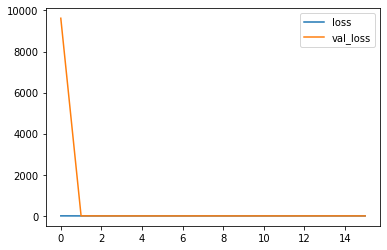

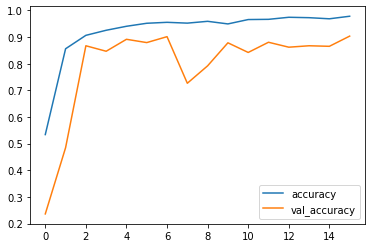

In [ ]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
valid_cm = get_confusion_matrix(validation_path, len(validation_image_files))



generating confusion matrix  9957
Found 9957 images belonging to 4 classes.
8/8 [==============================] - 2s 130ms/step
generating confusion matrix  2487
Found 2487 images belonging to 4 classes.
6/6 [==============================] - 1s 172ms/step


Confusion matrix, without normalization
[[2497    0    0    0]
 [   0 2483    0    0]
 [   0    0 2478    0]
 [ 350   21   89 2039]]


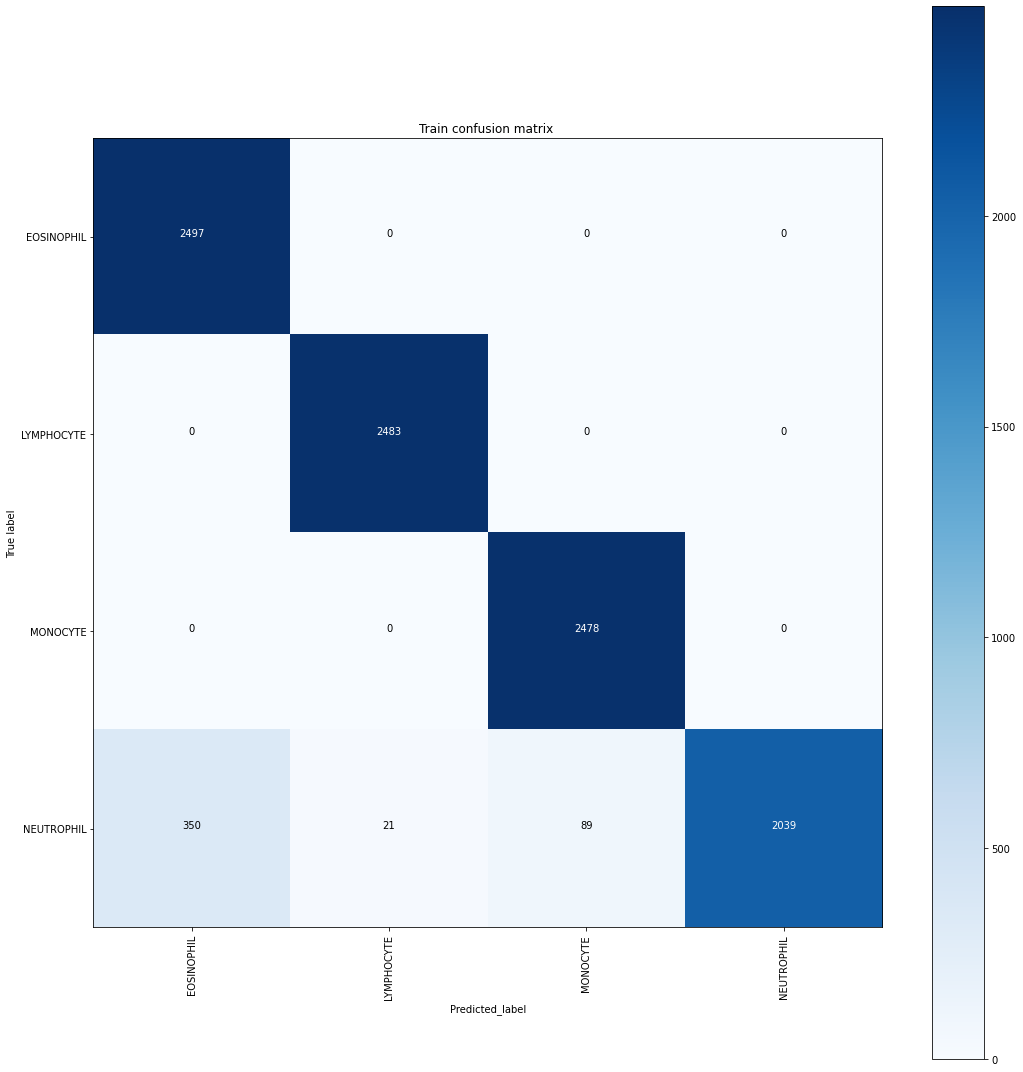

In [ ]:
plot_confusion_matrix(cm, labels, title="Train confusion matrix ")

Confusion matrix, without normalization
[[545   5   9  64]
 [  0 620   0   0]
 [  0   0 609  11]
 [140   0  21 463]]


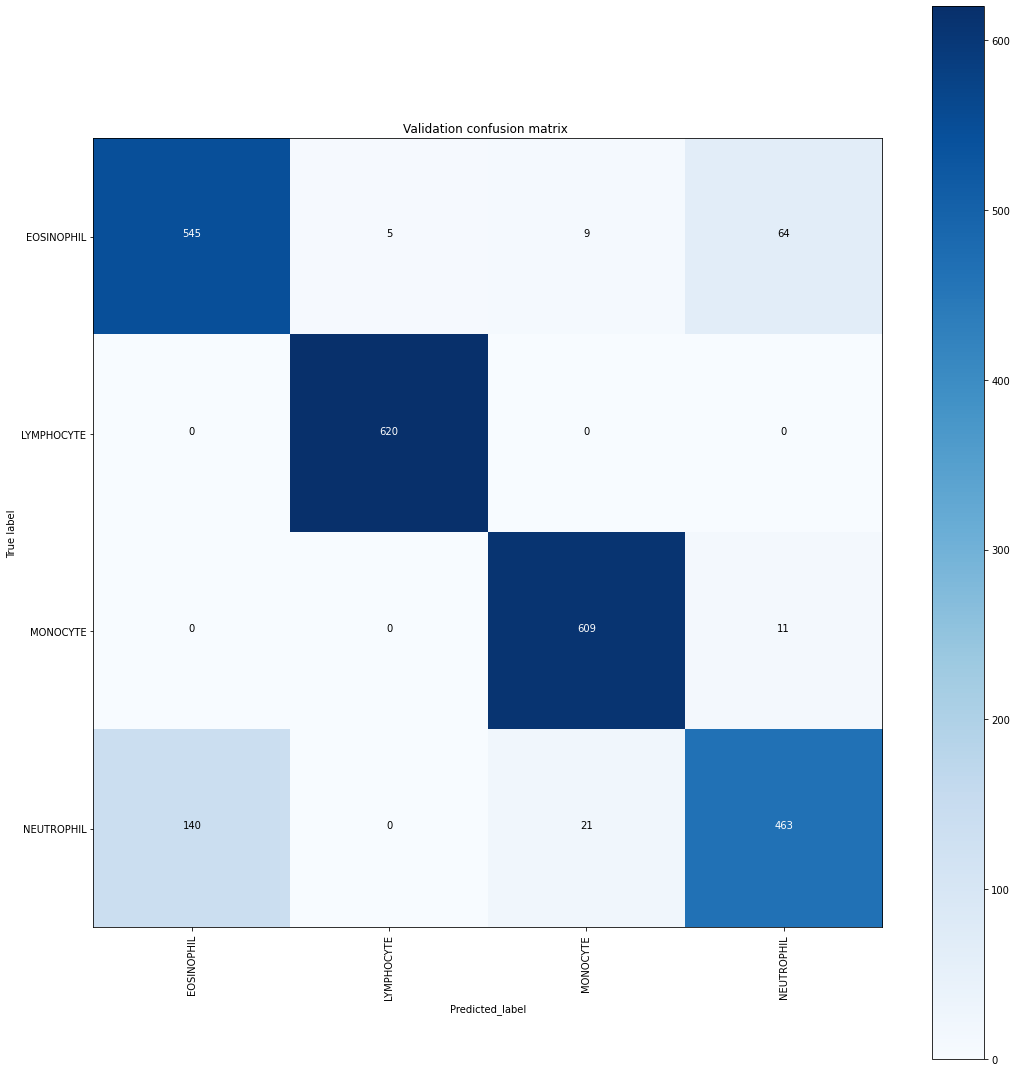

In [ ]:
plot_confusion_matrix(valid_cm, labels, title="Validation confusion matrix ")

In [ ]:
np.trace(cm)/cm.sum()

0.9538013457868836

In [ ]:
np.trace(valid_cm)/valid_cm.sum()

0.8994772818657016